In [422]:
# Import statements
import geopandas
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Task 1

The first file 'buildings.sample.geojson' can be read using the geopandas library into a geodataframe

In [3]:
# Loads data into geodataframe, assumes this notebook is in the same directory as the 'data' folder
gdf_buildings = geopandas.read_file('./data/buildings.sample.geojson')

In [4]:
# Show dataframe
gdf_buildings

,fid,final_roof,geometry
0,341.0,9,"MULTIPOLYGON (((-1.84291 50.72365, -1.84292 50..."
1,342.0,7,"MULTIPOLYGON (((-1.84253 50.72373, -1.84252 50..."
2,343.0,9,"MULTIPOLYGON (((-1.84229 50.72376, -1.84228 50..."
3,361.0,7,"MULTIPOLYGON (((-1.84163 50.72326, -1.84163 50..."
4,362.0,9,"MULTIPOLYGON (((-1.84216 50.72341, -1.84214 50..."
5,363.0,7,"MULTIPOLYGON (((-1.84274 50.72334, -1.84274 50..."
6,517.0,3,"MULTIPOLYGON (((-1.84249 50.72337, -1.84248 50..."
7,580.0,3,"MULTIPOLYGON (((-1.84197 50.72338, -1.84188 50..."
8,666.0,4,"MULTIPOLYGON (((-1.84195 50.72368, -1.84219 50..."
9,705.0,4,"MULTIPOLYGON (((-1.84167 50.72371, -1.84191 50..."


First we check the shape of the dataframe

In [5]:
# Shape of dataframe
gdf_shape = gdf_buildings.shape
print("The dataframe has", gdf_shape[0], "rows and", gdf_shape[1], "columns.")

The dataframe has 10 rows and 3 columns.


Then the datatypes in each column

In [6]:
# Datatypes of columns
print("Column 'fid' has datatype:", gdf_buildings['fid'].dtype)
print("Column 'final_roof' has datatype:", gdf_buildings['final_roof'].dtype)
print("Column 'geometry' has datatype:", gdf_buildings['geometry'].dtype)

Column 'fid' has datatype: float64
Column 'final_roof' has datatype: object
Column 'geometry' has datatype: geometry


'final_roof' returns the datatype object, this is because pandas stores string data as an object due to the variable length of strings. Checking the type of the first entry confirms that the colum contains string data.

In [7]:
# Datatype of first entry in 'final_roof' column
print("Entries in 'final_roof' have datatype:", type(gdf_buildings['final_roof'][0]))

Entries in 'final_roof' have datatype: <class 'str'>


The most interesting column of this geodataframe is the 'geometry' column, which contains the geodataframe's geoseries, accessible through the geometry attribute

In [8]:
# The geoseries
gdf_buildings.geometry

0    MULTIPOLYGON (((-1.84291 50.72365, -1.84292 50...
1    MULTIPOLYGON (((-1.84253 50.72373, -1.84252 50...
2    MULTIPOLYGON (((-1.84229 50.72376, -1.84228 50...
3    MULTIPOLYGON (((-1.84163 50.72326, -1.84163 50...
4    MULTIPOLYGON (((-1.84216 50.72341, -1.84214 50...
5    MULTIPOLYGON (((-1.84274 50.72334, -1.84274 50...
6    MULTIPOLYGON (((-1.84249 50.72337, -1.84248 50...
7    MULTIPOLYGON (((-1.84197 50.72338, -1.84188 50...
8    MULTIPOLYGON (((-1.84195 50.72368, -1.84219 50...
9    MULTIPOLYGON (((-1.84167 50.72371, -1.84191 50...
Name: geometry, dtype: geometry

These polygons can be plotted, showing the outlines of some buildings

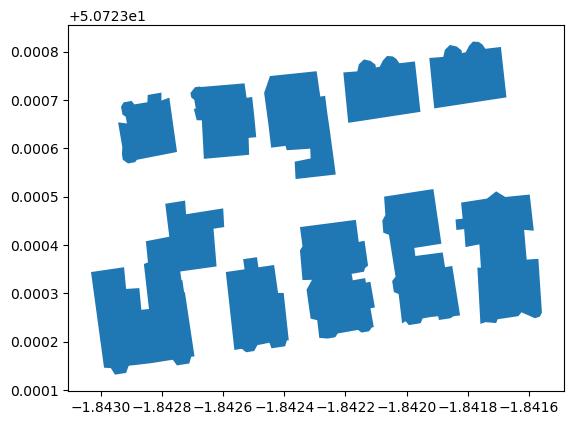

In [15]:
# Plot the polygon data
gdf_buildings.plot();

The second file 'image.grey.tif' is a GeoTIFF file that can be read using the rasterio library to create a raster dataset

In [24]:
# Read .tiff file
geo_image = rasterio.open('./data/image.grey.tif')

We can check the dataset (image) size

In [51]:
# Image width and height
width = geo_image.width
height = geo_image.height

print("Width: ", width)
print("Height: ", height)

Width:  556
Height:  289


A raster dataset is different from a typical image in that its pixels are mapped to regions on the earth's surface, we can find this location information using the bounds attribute. These bounds match the location of the polygons from earlier.

In [26]:
# Image bounds
geo_image.bounds

BoundingBox(left=-1.84308, bottom=50.72309, right=-1.84151, top=50.72391)

A raster dataset can also contain many bands of information, we can list the number of bands using the indexes attribute

In [30]:
# List image bands
geo_image.indexes

(1,)

In [32]:
# Read single band
geo_image.read(1)

array([[-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38,  1.1780000e+03,  1.0790000e+03, ...,
         1.3850000e+03,  1.3650000e+03, -3.4028235e+38],
       [-3.4028235e+38,  8.7900000e+02,  8.9900000e+02, ...,
         1.4180000e+03,  1.3890000e+03, -3.4028235e+38],
       ...,
       [-3.4028235e+38,  1.3940000e+03,  1.2580000e+03, ...,
         1.4490000e+03,  1.4730000e+03, -3.4028235e+38],
       [-3.4028235e+38,  1.3270000e+03,  1.3180000e+03, ...,
         1.4580000e+03,  1.4240000e+03, -3.4028235e+38],
       [-3.4028235e+38,  7.0670000e+03,  2.2026000e+04, ...,
         0.0000000e+00,  0.0000000e+00, -3.4028235e+38]], dtype=float32)

We can display the image using rasterio.plot.show, doing this we can make out the shapes of the building polygons from the earlier file

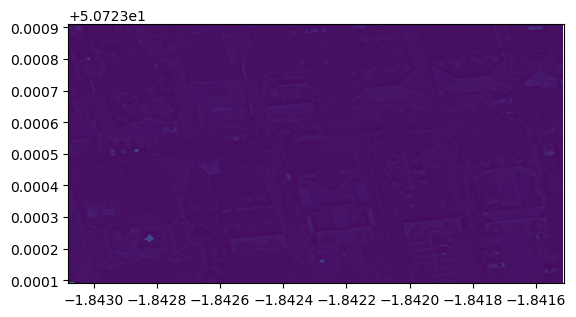

In [246]:
# Show raster iamge
show(geo_image);

However, the image is hard to see due to the outliers present. We can clip the image data to remove these outliers. First we can make a histogram using all of the values in the image

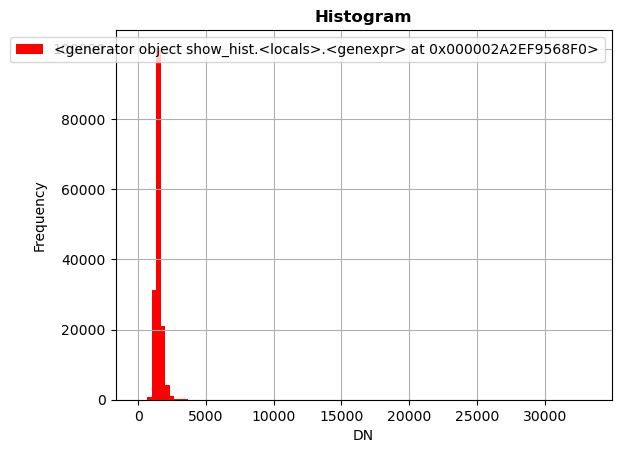

In [231]:
# Show histogram of raw image
show_hist(geo_image, bins=100, lw=0.0, stacked=False, title="Histogram");

This can be followed by an initial clipping to make the histogram easier to read, and another more detailed histogram

In [175]:
# Clip extreme values
half_clipped_geo_image = np.clip(geo_image.read(1), 0, 5000)

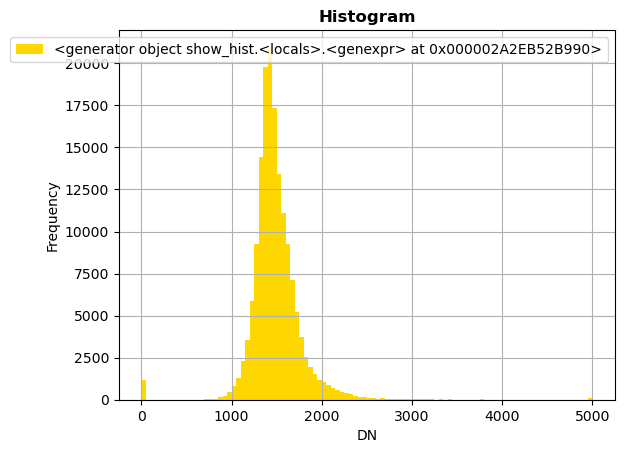

In [176]:
# Show second histogram
show_hist(half_clipped_geo_image, bins=100, lw=0.0, stacked=False, title="Histogram");

This histogram gives us a better idea of the range of values in the image, and allows us to perform a more precise clipping

In [177]:
# Clip more precisely
clipped_geo_image = np.clip(half_clipped_geo_image, 1000, 2200)

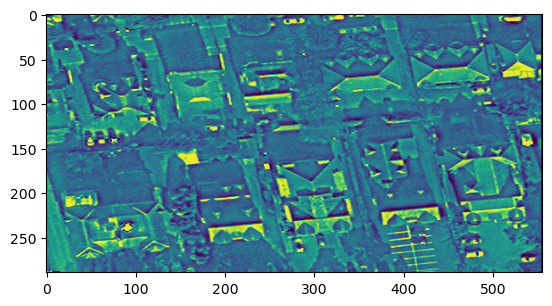

In [198]:
# Show clipped raster image
show(clipped_geo_image);

We now want to overlay the buildings from the geodataframe onto this raster image, to do that we need to transform them into the correct coordinate system. We can do that using the rasterio.features.rasterize function.

In [291]:
# Extract building shapes from geodataframe
buildings = [shapes for shapes in gdf_buildings.geometry]

# Rasterize the buildings using the shape and coordinate system of the raster image
rasterized_image = rasterize(buildings, out_shape = geo_image.shape, transform = geo_image.transform)

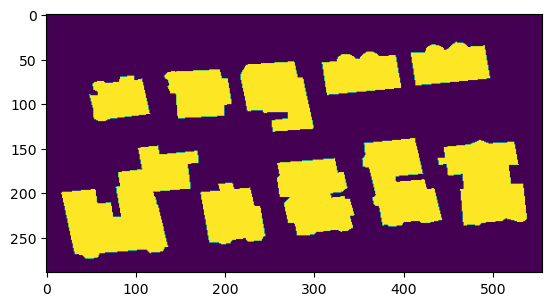

In [311]:
# Show rasterized image
plt.imshow(rasterized_image);

This rasterized image can then be used as a mask to overlay the building shapes onto the clipped image

In [310]:
rasterized_image[rasterized_image == 1] = 100

In [313]:
# Copy clipped_geo_image
overlayed_geo_image = clipped_geo_image
# Where rasterized image values equal 1, set overlayed_geo_image values to equal 2200
overlayed_geo_image[rasterized_image == 1] = 2200

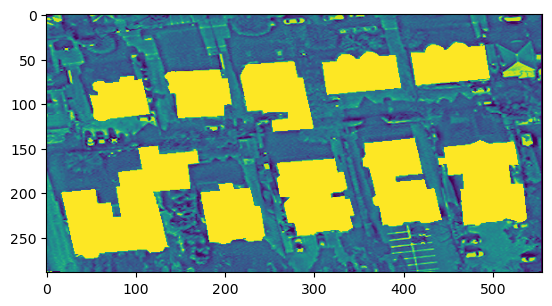

In [314]:
# Show the overlayed image
plt.imshow(overlayed_geo_image);

# Task 2

Firstly we want to read 'buildings.scv' into a dataframe

In [393]:
# Read into dataframe
df = pd.read_csv('./data/buildings.csv')

In [394]:
# Show dataframe
df

,roof_type1,address,latitude,longitude,height_m,area_m2,city,roof_mat
0,7,2203A GEELONG ROAD MOUNT HELEN 3350,-37.639552,143.886819,8,425,BALLARAT,1
1,7,2A WIRREANDA DRIVE MOUNT HELEN 3350,-37.638295,143.912613,3,403,BALLARAT,1
2,1,2133 GEELONG ROAD MOUNT HELEN 3350,-37.637520,143.883370,5,178,BALLARAT,1
3,1,2131 GEELONG ROAD MOUNT HELEN 3350,-37.637250,143.883390,3,135,BALLARAT,1
4,2,614 YANKEE FLAT ROAD MOUNT HELEN 3350,-37.637522,143.913676,3,350,BALLARAT,2
...,...,...,...,...,...,...,...,...
42841,3,901 DOUBLE SPRINGS LN,32.946791,-97.226593,7,65,KELLER,3
42842,4,1554 PEPPERTREE CT,32.900562,-97.219857,5,482,KELLER,3
42843,9,412 SILVERADO TR,32.939083,-97.220111,10,350,KELLER,3
42844,4,233 OVERLEAF ST,32.936757,-97.232178,7,388,KELLER,3


Latitude, longitude, height and area are all continuous data, roof type and city are categorical and address is free text. We will make use of all columns of data except for the address column. Continuous data is easy to use with classification algorithms but categorical data is not, we do not want the classifier erroneously interpreting category 3 to have a greater value than category 2. To solve this issue and be able to use the categorical data we will use one hot encoding. The next cell appends a column for every category of both sets of categorical data.

In [395]:
# Append columns for the one hot encoding of the categories in roof_type1
one_hot_type_df = pd.get_dummies(df['roof_type1'], prefix = 'roof_type1')
df = df.join(one_hot_type_df)

# Append columns for the one hot encoding of the categories in city
one_hot_city_df = pd.get_dummies(df['city'], prefix = 'city')
df = df.join(one_hot_city_df)

This creates a much larger dataframe

In [396]:
df

,roof_type1,address,latitude,longitude,height_m,area_m2,city,roof_mat,roof_type1_1,roof_type1_2,...,roof_type1_4,roof_type1_5,roof_type1_6,roof_type1_7,roof_type1_8,roof_type1_9,roof_type1_10,roof_type1_11,city_BALLARAT,city_KELLER
0,7,2203A GEELONG ROAD MOUNT HELEN 3350,-37.639552,143.886819,8,425,BALLARAT,1,0,0,...,0,0,0,1,0,0,0,0,1,0
1,7,2A WIRREANDA DRIVE MOUNT HELEN 3350,-37.638295,143.912613,3,403,BALLARAT,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,1,2133 GEELONG ROAD MOUNT HELEN 3350,-37.637520,143.883370,5,178,BALLARAT,1,1,0,...,0,0,0,0,0,0,0,0,1,0
3,1,2131 GEELONG ROAD MOUNT HELEN 3350,-37.637250,143.883390,3,135,BALLARAT,1,1,0,...,0,0,0,0,0,0,0,0,1,0
4,2,614 YANKEE FLAT ROAD MOUNT HELEN 3350,-37.637522,143.913676,3,350,BALLARAT,2,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42841,3,901 DOUBLE SPRINGS LN,32.946791,-97.226593,7,65,KELLER,3,0,0,...,0,0,0,0,0,0,0,0,0,1
42842,4,1554 PEPPERTREE CT,32.900562,-97.219857,5,482,KELLER,3,0,0,...,1,0,0,0,0,0,0,0,0,1
42843,9,412 SILVERADO TR,32.939083,-97.220111,10,350,KELLER,3,0,0,...,0,0,0,0,0,1,0,0,0,1
42844,4,233 OVERLEAF ST,32.936757,-97.232178,7,388,KELLER,3,0,0,...,1,0,0,0,0,0,0,0,0,1


We then select the features we want to use, selecting all columns containing continuous data and all of the columns containing the one hot encodings of the categorical data. We exclude the address text column and the two categorical columns.

In [414]:
# Set features
features = ['latitude', 'longitude', 'height_m', 'area_m2', 'roof_type1_1', 'roof_type1_2',
            'roof_type1_3', 'roof_type1_4', 'roof_type1_5', 'roof_type1_6', 'roof_type1_7',
            'roof_type1_8', 'roof_type1_9', 'roof_type1_10', 'roof_type1_11', 'city_BALLARAT',
            'city_KELLER']

We then load in our features and target attribute, and perform train test splitting with a ratio of 80/20

In [416]:
# Sort the dataframe into x and y
x = df[features]
y = df['roof_mat']

# Train test split x and y into training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

We will train 2 models on the training dataset to test which better learns to predict on the test dataset, a logistic regression model and a naive bayes model. First we train the logistic regression model.

In [420]:
# Define logistic regression model
model_log = linear_model.LogisticRegression()

# Train model on training dataset
model_log.fit(x_train, y_train)

C:\Users\Jamie\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

We then use that model to predict on the testing dataset

In [425]:
# Predict on test dataset
y_pred = model_log.predict(x_test)

# Display confusion matrix
print(confusion_matrix(y_test, y_pred))

# Display classification report
print(classification_report(y_test, y_pred))

[[  11  128    8   30]
 [   4 1745 1014   70]
 [   0  858 2067   15]
 [   0   11    8 2601]]
              precision    recall  f1-score   support

           0       0.73      0.06      0.11       177
           1       0.64      0.62      0.63      2833
           2       0.67      0.70      0.68      2940
           3       0.96      0.99      0.97      2620

    accuracy                           0.75      8570
   macro avg       0.75      0.59      0.60      8570
weighted avg       0.75      0.75      0.74      8570



The logistic regression model predicted with an accuracy of 0.75 on the test dataset. It achieved a weighted average precision of 0.75, recall of 0.75 and f1-score of 0.74. It learned to predict class 3 very well achieving an f1-score of 0.97. Classes 1 and 2 did okay with 0.63 and 0.68. The model did badly on class 0 with an f1-score of 0.11. The precision for class 0 was 0.73, but the recall was 0.06. This means that when it did predict class 0 it was usually correct, but that almost all instances of class 0 it missed, this can be seen looing at the accompanying confusion matrix where most class 0 predictions were predicted as class 1. This poor performance is likely because the number of instances of class 0 in the training dataset was very low at only 177, the training dataset had a large class imbalance, meaning that the classifier struggled to learn to predict class 0.

The other model to be trained was a naive bayes model.

In [426]:
# Define Naive bayes model
model_gnb = naive_bayes.GaussianNB()

# Train model on training dataset
model_gnb.fit(x_train, y_train)

GaussianNB()

In [427]:
# Predict on test dataset
y_pred = model_gnb.predict(x_test)

# Display confusion matrix
print(confusion_matrix(y_test, y_pred))

# Display classification report
print(classification_report(y_test, y_pred))

[[ 146   16   14    1]
 [ 275  353 2148   57]
 [  21   73 2833   13]
 [   2    3   16 2599]]
              precision    recall  f1-score   support

           0       0.33      0.82      0.47       177
           1       0.79      0.12      0.22      2833
           2       0.57      0.96      0.71      2940
           3       0.97      0.99      0.98      2620

    accuracy                           0.69      8570
   macro avg       0.67      0.73      0.60      8570
weighted avg       0.76      0.69      0.63      8570



The naive bayes model predicted okay on the test dataset with an accuracy of 0.69, 6 points lower than the logistic regression model. Its weighted average precision was o.76 (higher), recall was 0.69 (lower) and f1-was 0.63 (much lower). Class 3 was again the highest scoring with a similar f1-score of 0.98, class 2 did better with a score of 0.71, class 1 did much worse with a score of 0.22 and class 0 did much better with a score of 0.47. Overall the naive bayes model predicted worse than the logistic regression. It scored much better on class 0 but also much worse on class 1. Making a decision based on the overall average accuracy and f1-scores I would recommend using the logistic regression model.

The strengths of the chosen logistic regression model are its prediction accuracy on class 3, and to a lesser extent classes 1 and 2. Its obvious weakness is its inability to predict for class 0. Recommended future actions are to try and use the textual information in the address category to add to the models predictions. This would likely be done using NLP techniques such as tokenisation to split up the addresses and then identifying which tokens of the address strings represent relevant information that can be used as features.